In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [26]:
#Uses gpu if available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(0)
batch_size = 128

#Downloads datasets
image_size = (224, 224)
transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = torchvision.datasets.Imagenette(root='./data', download=True, transform=transform) #Set download to true first time
class_names = dataset.classes

#Split for cross validation
test_size = len(dataset) // 6
train_size = len(dataset) - test_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#Creates DataLoaders for each set
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [27]:
#Defines class for a residual block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, halving):
        super().__init__()
        
        #If halving is true, the feature size is cut in half and the out_channels is doubled
        out_channels = in_channels
        stride1 = 1
        stride2 = 1
        if halving:
            out_channels *= 2
            stride1 = 2

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        #Normal convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        out = F.relu(x)
        return out

#Defines Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self,):
        super().__init__()

        #Convolutional layers/blocks for 18-layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=5, stride=2, padding=2)

        self.conv_block1 = ConvBlock(in_channels=64, kernel_size=3, halving=False)
        self.conv_block2 = ConvBlock(in_channels=64, kernel_size=3, halving=False)

        self.conv_block3 = ConvBlock(in_channels=64, kernel_size=3, halving=True)
        self.conv_block4 = ConvBlock(in_channels=128, kernel_size=3, halving=False)

        self.conv_block5 = ConvBlock(in_channels=128, kernel_size=3, halving=True)
        self.conv_block6 = ConvBlock(in_channels=256, kernel_size=3, halving=False)

        self.conv_block7 = ConvBlock(in_channels=256, kernel_size=3, halving=True)
        self.conv_block8 = ConvBlock(in_channels=512, kernel_size=3, halving=False)

        self.pool2 = nn.AvgPool2d(kernel_size=7,stride=1)

        #Fully connected layer
        self.flatten = nn.Flatten()
        self.out = nn.Linear(in_features=512, out_features=10)


    def forward(self, x):
        #Convolutional layers\blocks with ReLU activation function
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv_block1(x)
        x = self.conv_block2(x)

        x = self.conv_block3(x)
        x = self.conv_block4(x)

        x = self.conv_block5(x)
        x = self.conv_block6(x)

        x = self.conv_block7(x)
        x = self.conv_block8(x)

        x = self.pool2(x)

        #Fully connected layer with ReLU activation
        x = self.flatten(x)
        out = F.relu(self.out(x))
        
        return out

In [28]:
#Iterates through a training epoch while displaying performance metrics by batch
def train_epoch(network, optimizer, criterion):
    network.train(True)
    running_loss = 0.0
    running_accuracy = 0.0

    for batch_index, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = network(inputs)
        num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += num_correct / batch_size

        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_index % 20 == 19:
            avg_loss_across_batches = running_loss / 20
            avg_acc_across_batches = (running_accuracy / 20) * 100
            print('Batch{0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1, avg_loss_across_batches, avg_acc_across_batches))
            running_loss = 0
            running_accuracy = 0

#Optional method to evaluate performance on validation data
def validate_epoch(network, criterion):
    network.train(False)
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs = network(inputs)
            num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += num_correct / batch_size

            loss = criterion(outputs, labels)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(testloader)
    avg_accuracy_across_batches = (running_accuracy / len(testloader)) * 100
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches, avg_accuracy_across_batches))
    print('*****************************************')
    print()
            

In [29]:
#Sets up CNN, optimizer, and loss function
cnn = CNN()
cnn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.0001)

#Trains the CNN
num_epochs = 10
for i in range(num_epochs):
    print(f"Epoch {i+1}")
    train_epoch(cnn, optimizer, criterion)
    validate_epoch(cnn, criterion)

Epoch 1
Batch20, Loss: 2.092, Accuracy: 26.1%
Batch40, Loss: 1.783, Accuracy: 40.2%
Batch60, Loss: 1.643, Accuracy: 46.8%
Val Loss: 1.842, Val Accuracy: 39.9%
*****************************************

Epoch 2
Batch20, Loss: 1.501, Accuracy: 51.9%
Batch40, Loss: 1.444, Accuracy: 53.6%
Batch60, Loss: 1.298, Accuracy: 59.3%
Val Loss: 2.016, Val Accuracy: 37.2%
*****************************************

Epoch 3
Batch20, Loss: 1.201, Accuracy: 62.1%
Batch40, Loss: 1.130, Accuracy: 64.4%
Batch60, Loss: 1.149, Accuracy: 63.8%
Val Loss: 1.652, Val Accuracy: 45.8%
*****************************************

Epoch 4
Batch20, Loss: 1.012, Accuracy: 67.8%
Batch40, Loss: 1.033, Accuracy: 67.4%
Batch60, Loss: 0.988, Accuracy: 69.1%
Val Loss: 1.568, Val Accuracy: 50.9%
*****************************************

Epoch 5
Batch20, Loss: 0.850, Accuracy: 73.8%
Batch40, Loss: 0.857, Accuracy: 73.0%
Batch60, Loss: 0.900, Accuracy: 71.0%
Val Loss: 1.196, Val Accuracy: 59.8%
*********************************

In [35]:
#Verifies accuracy on test data set
total_correct = 0
cnn.train(False)
for batch_index, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(inputs)
        total_correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()
print(f"Accuracy {(total_correct/len(test_dataset)) * 100}")

Accuracy 64.32192648922687


In [34]:
torch.save(cnn, 'DeepCNNParams.pth')

In [32]:
#Loads previously trained models
with torch.serialization.safe_globals([CNN]):
    cnn = torch.load('DeepCNNParams.pth', weights_only=False)
cnn.to(device)
test_iter = iter(testloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label: chain saw
Guess label: chain saw


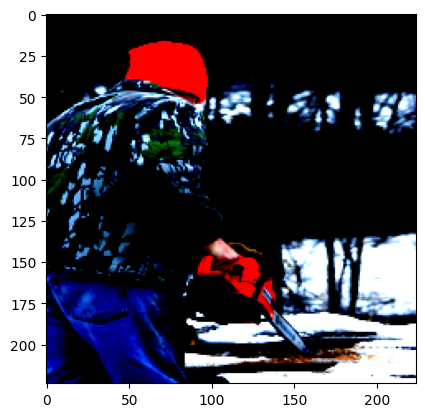

In [33]:
#Shows an image along with a guess and true label
images, true_labels = next(test_iter)
cnn.train(False)
guess_labels = cnn(images.to(device))
np_imgs = images.numpy()
np_img = np_imgs[0]
guess_label = torch.argmax(guess_labels[0]).item()
print(f"True label: {class_names[true_labels[0]][0]}")
print(f"Guess label: {class_names[guess_label][0]}")
plt.imshow(np_img.transpose((1, 2, 0)))